In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
import pickle
import yaml
import dcargs
import pandas as pd

from experiment import ExperimentParameters
import glob
from tqdm import tqdm
from yaml.loader import SafeLoader

path = "/home/mohsen/Project/colab/collective-decison-making-with-direl/results/"
sys.path.append(path)


In [2]:
from multiprocessing import Pool

def parse_experiment_data(file_path):
#     print("File Path is: " + file_path)

    pickleFileName = file_path+"/data.pickle5"
    yamlFileName = file_path+"/config.yaml"

    with open(pickleFileName, "rb") as f:
        resFile = pickle.load(f)

    with open(yamlFileName, 'r') as f:
        configData = dcargs.from_yaml(ExperimentParameters, f)
        
    
    n_agents = configData.network_params.n_agents
    steps = configData.steps
    z_gt = configData.true_value
    
    # not checked yet
    mean_agent_measurement_noise = configData.network_params.mean_agent_measurement_noise
    scalar_param1 = configData.network_params.scalar_param1
    std_agent_measurement_noise = configData.network_params.std_agent_measurement_noise
    
    colData = resFile['collective_data']
    adjc = colData['connectivity']
    agntData = colData['agent_data']

    # print("nAgents: " + str(n_agents) + ", steps: " + str(steps));
    # print("agnt data: ", len(agntData))

    zArr = np.zeros((n_agents,steps))
    pArr = zArr.copy()

    for i in range(n_agents):
        z = agntData[i].belief_mean
        std = agntData[i].belief_std
        zArr[i,:] = z
        pArr[i,:] = std

    avgZArr = np.mean(zArr, axis=0)
    E_t = (avgZArr-z_gt)**2
    E_p2 = (zArr - avgZArr)**2
    E_p = np.mean(E_p2, axis=0)
    E_a = E_t + E_p

    d = {"Trueness Error": E_t, "Precision Error": E_p, "Accuracy Error": E_a, "Collective Mean": avgZArr, 
         "Number of Agents": [n_agents for _ in range(steps)], "True Value": [z_gt for _ in range(steps)], 
         "Timestep": [i for i in range(steps)],
         "mean agent measurement noise": [mean_agent_measurement_noise for _ in range(steps)],
         "std agent measurement noise": [std_agent_measurement_noise for _ in range(steps)],
         "scalar param1": [scalar_param1 for _ in range(steps)],
         "adjc": adjc}
    
    return pd.DataFrame.from_dict(d)

# def process_file(base_file_path):
def parse_experiments(base_file_path):
    pathes = glob.glob(os.path.join(base_file_path, "*"))
    dataframes = []
    for p in tqdm(pathes):
        dataframes.append(parse_experiment_data(p))
    #   dataframes = [parse_experiment_data(p) for p in tqdm(pathes)]
    return pd.concat(dataframes, ignore_index=True)

experiment_path = "/home/mohsen/Project/colab/collective-decison-making-with-direl/results/2022-09-02-15-37-36_test_grid_search"
df = parse_experiments(experiment_path)
df.to_pickle("/home/mohsen/Project/colab/collective-decison-making-with-direl/results/2022-09-02-15-37-36_test_grid_search_saved_df_withNet")


100%|██████████| 160000/160000 [4:01:05<00:00, 11.06it/s]  


In [2]:
pickleFileName = "/home/mohsen/Project/colab/collective-decison-making-with-direl/results/2022-09-02-15-37-36_test_grid_search_saved_df_withNet"

with open(pickleFileName, "rb") as f:
    df = pickle.load(f)

In [ ]:
import networkx as nx
import multiprocessing

pool = multiprocessing.Pool(10)

df.insert(0,"Netw num of Edges", -1)
df.insert(0,"Netw std degree", -1)
df.insert(0,"Netw mean degree", -1)

df.insert(0,"Netw std eigVec", -1)
df.insert(0,"Netw mean eigVec", -1)
df.insert(0,"Netw max eigVec", -1)

df.insert(0,"Netw std CC", -1)
df.insert(0,"Netw mean CC", -1)
df.insert(0,"Netw max CC", -1)




for i in range(10):
    G = nx.from_numpy_array(df[i]["adjc"].cpu().detach().numpy())
    df[i]["Netw num of Edges"] = G.number_of_edges()
    degreeDist = G.degree()
    df[i]["Netw std degree"] = np.std(degreeDist)
    df[i]["Netw mean degree"] = np.mean(degreeDist)

    eigVec = np.array(list(nx.eigenvector_centrality_numpy(G).values()))
    df[i]["Netw std eigVec"] = np.std(eigVec)
    df[i]["Netw mean eigVec"] = np.mean(eigVec)
    df[i]["Netw max eigVec"] = np.max(eigVec)

    clustCoef = np.array(list(nx.clustering(G).values()))
    df[i]["Netw std CC"] = np.std(clustCoef)
    df[i]["Netw mean CC"] = np.mean(clustCoef)
    df[i]["Netw max CC"] = np.max(clustCoef)
    

# df.to_pickle("/home/mohsen/Project/colab/collective-decison-making-with-direl/results/2022-09-02-15-37-36_test_grid_search_saved_df_withNet_postPro")

In [4]:
pickleFileName = "/home/mohsen/Project/colab/collective-decison-making-with-direl/results/2022-09-02-15-37-36_test_grid_search_saved_df_withNet_postPro"

with open(pickleFileName, "rb") as f:
    df = pickle.load(f)

EOFError: Ran out of input

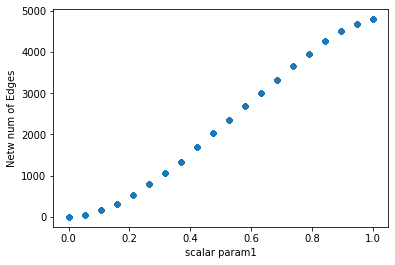

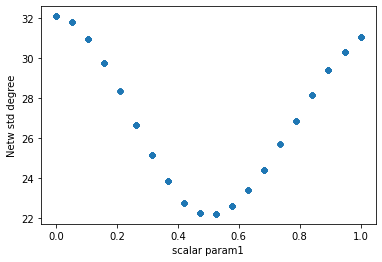

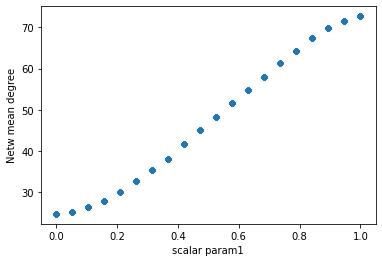

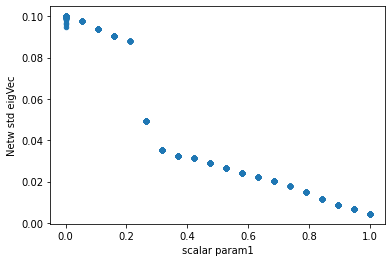

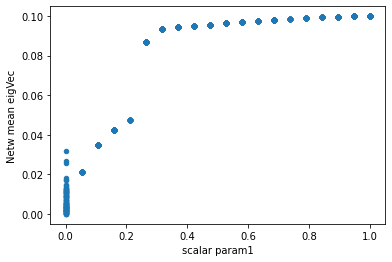

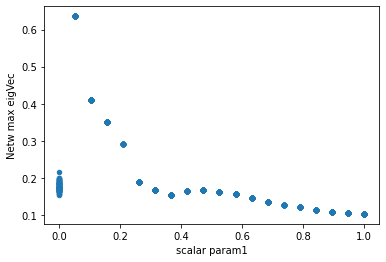

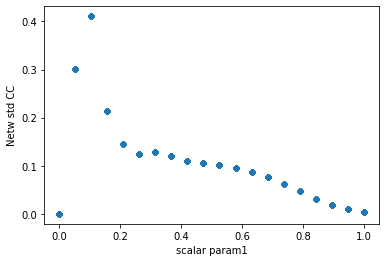

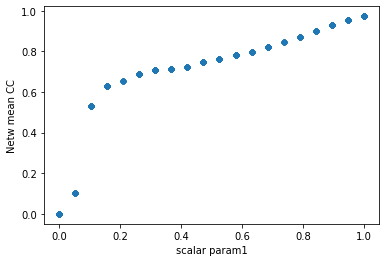

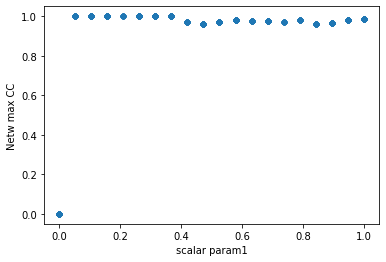

In [ ]:
df.plot.scatter(x="scalar param1",y="Netw num of Edges");
df.plot.scatter(x="scalar param1",y="Netw std degree");
df.plot.scatter(x="scalar param1",y="Netw mean degree");

df.plot.scatter(x="scalar param1",y="Netw std eigVec");
df.plot.scatter(x="scalar param1",y="Netw mean eigVec");
df.plot.scatter(x="scalar param1",y="Netw max eigVec");

df.plot.scatter(x="scalar param1",y="Netw std CC");
df.plot.scatter(x="scalar param1",y="Netw mean CC");
df.plot.scatter(x="scalar param1",y="Netw max CC");
# df.plot.hexbin(x="mean agent measurement noise",   y="scalar param1",C="Netw num of Edges", reduce_C_function=np.mean, gridsize=15);

In [ ]:
# df.insert(0,"number of edges", 2)
# from numpy.linalg import eig


eigCent = nx.eigenvector_centrality_numpy(G)
eigVec = np.array(list(eigCent.values()))
print(np.std(eigVec))
print(np.mean(eigVec))
print(np.max(eigVec))
print(np.min(eigVec))

clustCoef = np.array(list(nx.clustering(G).values()))
# print(np.sort(eigVec))

0.032456250977942774
0.09458642488463546
0.15334657730526802
0.02770669448440057


In [ ]:
import networkx as nx

def getNumEdges(pos, r2_link):
    nNode = len(pos)
    G = getNetworkFromPos(pos, r2_link)
    nEdge = G.number_of_edges()
    return nEdge, G

def getGiantCompNodeSize(G):
    connected = [n for n, d in G.degree() if d > 0]
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])
    return G0.number_of_nodes()

    